In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle

### Data splitting

In [2]:
def load_and_preprocess_data(test_size=0.33, random_state=42, multiclass=False):
    iris = load_iris()
    X = pd.DataFrame(iris.data, columns=iris.feature_names)
    y = iris.target if multiclass else (iris.target == 0).astype(int)  # Use all three classes for multiway classification if multiclass=True
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    return X_train, X_test, y_train, y_test

### Training the model

#### Perceptron

In [3]:
class Perceptron:
    def __init__(self, learning_rate=0.01, n_iters=1000):
        self.learning_rate = learning_rate
        self.n_iters = n_iters
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        for _ in range(self.n_iters):
            for idx, x_i in enumerate(X):
                linear_output = np.dot(x_i, self.weights) + self.bias
                y_predicted = self._unit_step_function(linear_output)
                
                update = self.learning_rate * (y[idx] - y_predicted)
                self.weights += update * x_i
                self.bias += update

    def predict(self, X):
        linear_output = np.dot(X, self.weights) + self.bias
        y_predicted = self._unit_step_function(linear_output)
        return y_predicted

    def _unit_step_function(self, x):
        return np.where(x >= 0, 1, 0)

#### SigmoidNeuron

In [4]:
class LogisticRegression:
    def __init__(self, learning_rate=0.01, n_iters=1000):
        self.learning_rate = learning_rate
        self.n_iters = n_iters
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        for _ in range(self.n_iters):
            linear_model = np.dot(X, self.weights) + self.bias
            y_predicted = self._sigmoid(linear_model)

            dw = (1 / n_samples) * np.dot(X.T, (y_predicted - y))
            db = (1 / n_samples) * np.sum(y_predicted - y)

            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

    def predict(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        y_predicted = self._sigmoid(linear_model)
        y_predicted_cls = [1 if i > 0.5 else 0 for i in y_predicted]
        return np.array(y_predicted_cls)

    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

#### SoftmaxNeuron

In [5]:
class SoftmaxRegression:
    def __init__(self, learning_rate=0.01, n_iters=1000):
        self.learning_rate = learning_rate
        self.n_iters = n_iters
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        n_classes = len(np.unique(y))
        self.weights = np.zeros((n_features, n_classes))
        self.bias = np.zeros(n_classes)

        y_one_hot = self._one_hot(y, n_classes)

        for _ in range(self.n_iters):
            linear_model = np.dot(X, self.weights) + self.bias
            y_predicted = self._softmax(linear_model)

            dw = (1 / n_samples) * np.dot(X.T, (y_predicted - y_one_hot))
            db = (1 / n_samples) * np.sum(y_predicted - y_one_hot, axis=0)

            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

    def predict(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        y_predicted = self._softmax(linear_model)
        return np.argmax(y_predicted, axis=1)

    def _softmax(self, x):
        exp = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp / np.sum(exp, axis=1, keepdims=True)

    def _one_hot(self, y, n_classes):
        one_hot = np.zeros((y.shape[0], n_classes))
        one_hot[np.arange(y.shape[0]), y] = 1
        return one_hot

### Metrics

In [6]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from itertools import cycle

def calculate_metrics(y_true, y_pred, multiclass=False):
    average_method = 'macro' if multiclass else 'binary'
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average=average_method)
    recall = recall_score(y_true, y_pred, average=average_method)

    if multiclass:
        y_true_binarized = label_binarize(y_true, classes=[0, 1, 2])
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(len(np.unique(y_true))):
            fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_pred == i)
            roc_auc[i] = auc(fpr[i], tpr[i])
        return accuracy, precision, recall, fpr, tpr, roc_auc
    else:
        fpr, tpr, _ = roc_curve(y_true, y_pred)
        roc_auc = auc(fpr, tpr)
        return accuracy, precision, recall, fpr, tpr, roc_auc

def plot_roc_curve(fpr, tpr, roc_auc, multiclass=False):
    if multiclass:
        colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
        plt.figure()
        for i, color in zip(range(len(fpr)), colors):
            plt.plot(fpr[i], tpr[i], color=color, lw=2,
                     label='ROC curve of class {0} (area = {1:0.2f})'
                     ''.format(i, roc_auc[i]))
        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic for Multi-Class')
        plt.legend(loc="lower right")
        plt.show()
    else:
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right")
        plt.show()

## TODO
### Overfitting check and regularization

In [7]:
# def check_overfitting(model, X_train, y_train, X_test, y_test):
#     y_train_pred = model.predict(X_train)
#     y_test_pred = model.predict(X_test)

#     train_accuracy = accuracy_score(y_train, y_train_pred)
#     test_accuracy = accuracy_score(y_test, y_test_pred)
    
#     print(f"Train Accuracy: {train_accuracy}")
#     print(f"Test Accuracy: {test_accuracy}")
    
#     if train_accuracy > test_accuracy + 0.1:
#         print("Overfitting detected. Applying regularization...")
#         return True
#     return False

# class LogisticRegressionWithRegularization(LogisticRegression):
#     def __init__(self, learning_rate=0.01, n_iters=1000, reg_strength=0.01):
#         super().__init__(learning_rate, n_iters)
#         self.reg_strength = reg_strength

#     def fit(self, X, y):
#         n_samples, n_features = X.shape
#         self.weights = np.zeros(n_features)
#         self.bias = 0

#         for _ in range(self.n_iters):
#             linear_model = np.dot(X, self.weights) + self.bias
#             y_predicted = self._sigmoid(linear_model)

#             dw = (1 / n_samples) * np.dot(X.T, (y_predicted - y)) + (self.reg_strength / n_samples) * self.weights
#             db = (1 / n_samples) * np.sum(y_predicted - y)

#             self.weights -= self.learning_rate * dw
#             self.bias -= self.learning_rate * db

Perceptron - Accuracy: 1.0, Precision: 1.0, Recall: 1.0, AUC: 1.0


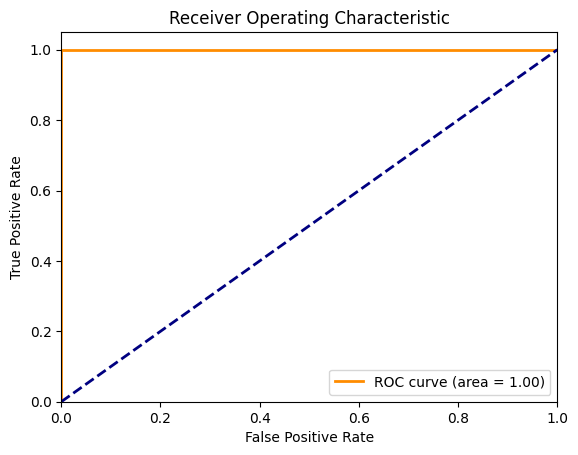

Logistic Regression - Accuracy: 1.0, Precision: 1.0, Recall: 1.0, AUC: 1.0


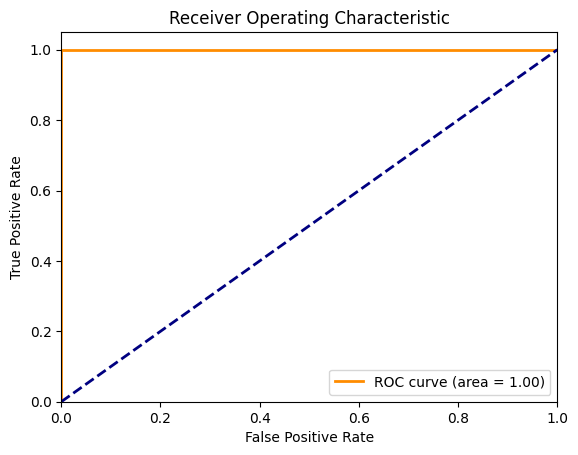

Softmax Regression - Accuracy: 0.86, Precision: 0.8985507246376812, Recall: 0.8444444444444444


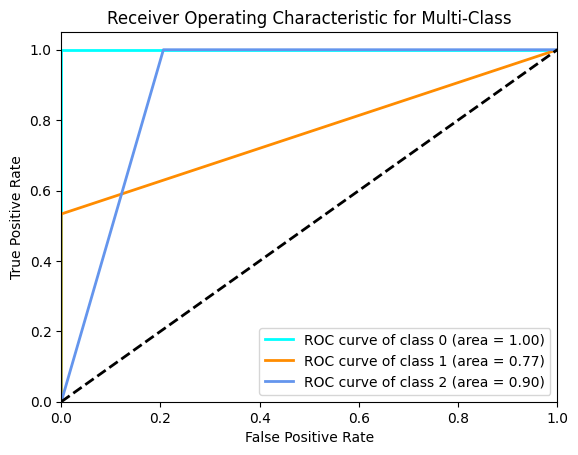

In [9]:
# Load and split data
X_train, X_test, y_train, y_test = load_and_preprocess_data()

# Perceptron Model
perceptron = Perceptron(learning_rate=0.01, n_iters=1000)
perceptron.fit(X_train, y_train)
y_pred_perceptron = perceptron.predict(X_test)
accuracy, precision, recall, fpr, tpr, roc_auc = calculate_metrics(y_test, y_pred_perceptron)
print(f"Perceptron - Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, AUC: {roc_auc}")
plot_roc_curve(fpr, tpr, roc_auc)

## Check for overfitting in Perceptron

# Sigmoid Neuron (Logistic Regression)
log_reg = LogisticRegression(learning_rate=0.01, n_iters=1000)
log_reg.fit(X_train, y_train)
y_pred_log_reg = log_reg.predict(X_test)
accuracy, precision, recall, fpr, tpr, roc_auc = calculate_metrics(y_test, y_pred_log_reg)
print(f"Logistic Regression - Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, AUC: {roc_auc}")
plot_roc_curve(fpr, tpr, roc_auc)

## Check for overfitting in Logistic Regression

# Load and split data for multi-class classification
X_train, X_test, y_train, y_test = load_and_preprocess_data(multiclass=True)

# Softmax Neuron for Multiway Classification
softmax_reg = SoftmaxRegression(learning_rate=0.01, n_iters=1000)
softmax_reg.fit(X_train, y_train)
y_pred_softmax = softmax_reg.predict(X_test)
accuracy, precision, recall, fpr, tpr, roc_auc = calculate_metrics(y_test, y_pred_softmax, multiclass=True)
print(f"Softmax Regression - Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}")
plot_roc_curve(fpr, tpr, roc_auc, multiclass=True)

## Check for overfitting in Softmax Regression